In [191]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import rcParams

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5

In [192]:
df = pd.read_csv('data/eps_quarter.csv')

df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


In [194]:
df['date'] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index('date', inplace=True)


# Display the dataframe
df.head()

,data
date,
1960-01-01,0.71
1960-04-01,0.63
1960-07-02,0.85
1960-10-01,0.44
1961-01-01,0.61


In [195]:
df.tail()

,data
date,
1979-10-01,9.99
1980-01-01,16.20
1980-04-01,14.67
1980-07-02,16.02
1980-10-01,11.61


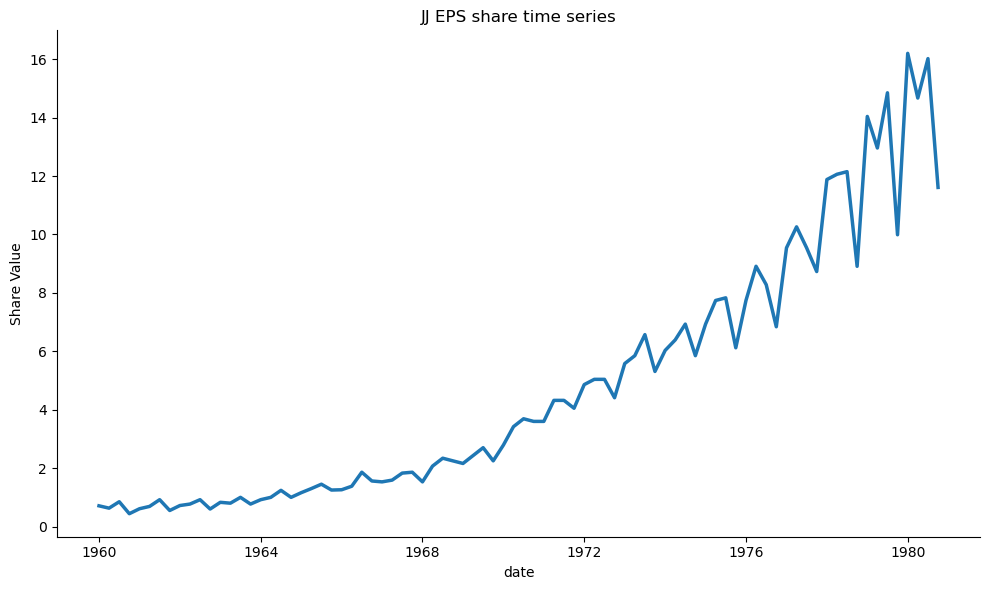

In [196]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['data'])
plt.title('JJ EPS share time series')

plt.xlabel('date')
plt.ylabel('Share Value')

plt.tight_layout()
plt.show()

In [197]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574735
p-value: 1.0


In [198]:
eps_diff = np.diff(df['data'], n=1)

In [199]:


ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804116
p-value: 0.9088542416911313


In [200]:
eps_diff2 = np.diff(eps_diff, n=1)



In [201]:
ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793187
p-value: 0.006051099869603033


In [202]:
df_diff = pd.DataFrame({'eps_diff2': eps_diff2})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]


print(len(train))
print(len(test))

73
9


In [203]:
TRAIN_LEN = len(train)
HORIZON = len(test)

1978-04-02 00:00:00
1980-10-01 00:00:00


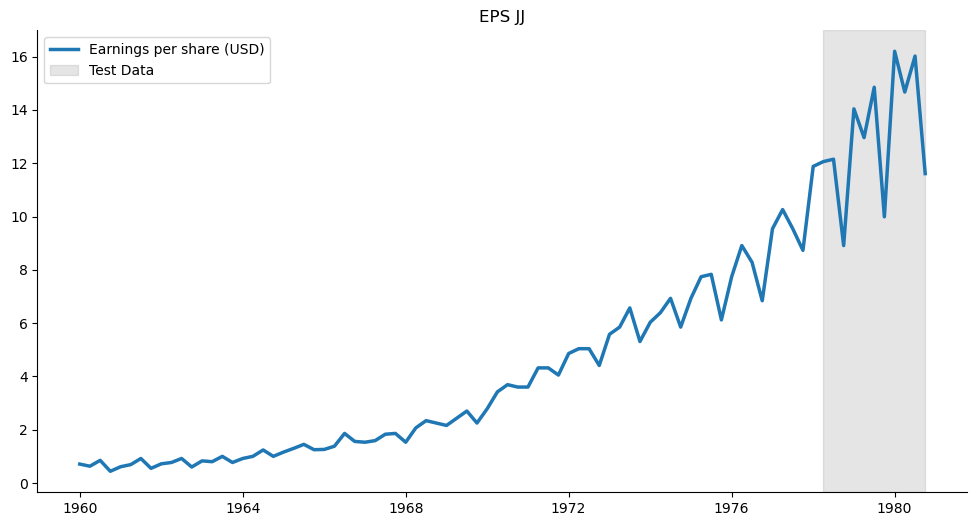

In [204]:
test_start = df.index[TRAIN_LEN]  # Start of the test data
test_end = df.index[-1]  # End of the test data

print(test_start)
print(test_end)
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['data'], label='Earnings per share (USD)')

# Highlight the test data range
plt.axvspan(test_start, test_end, color='#808080', alpha=0.2, label="Test Data")

plt.title('EPS JJ')
plt.legend()
plt.show()

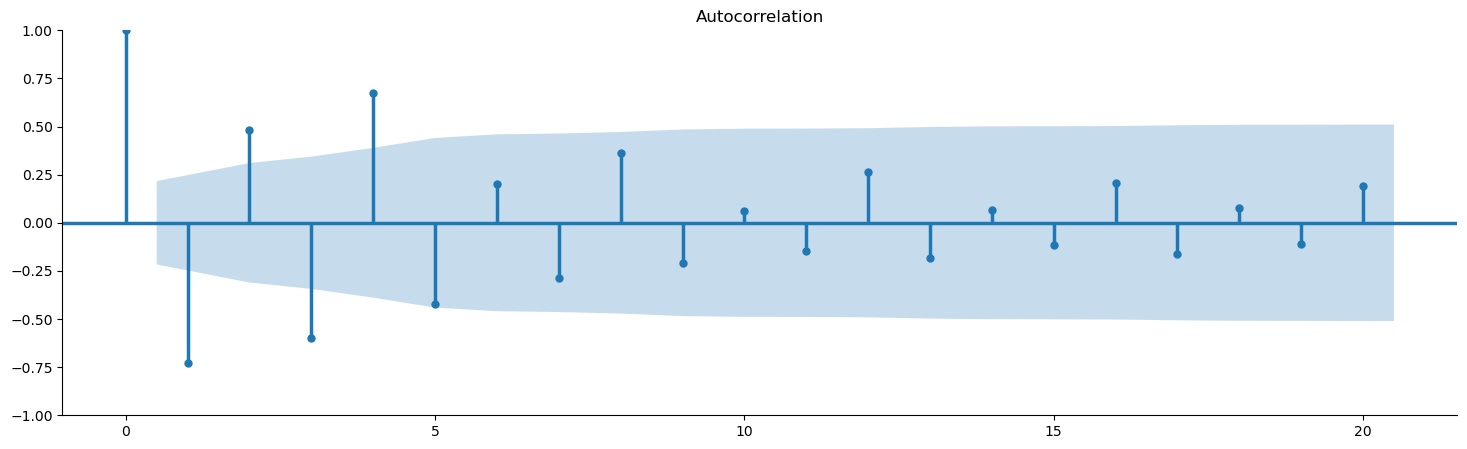

In [205]:
plot_acf(eps_diff2)
plt.show()

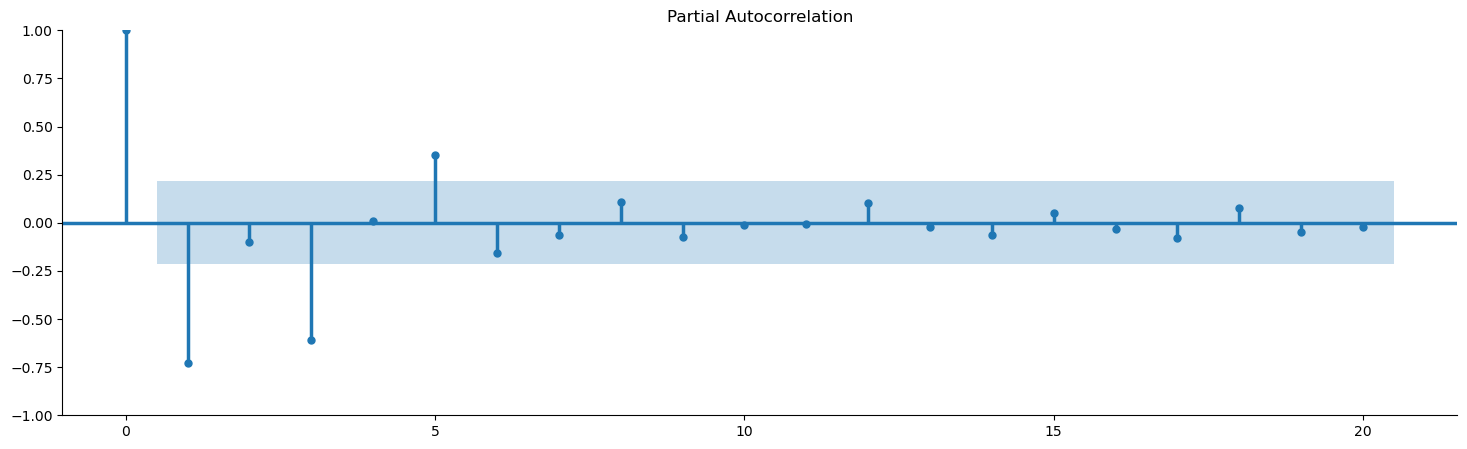

In [206]:
plot_pacf(eps_diff2)
plt.show()

In [207]:


def optimize_ARMA(endog: pd.Series, p_range: list, q_range: list) -> pd.DataFrame:
    results = []

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(endog, order=(p, 0, q)).fit()
                aic = model.aic  # Akaike Information Criterion
                bic = model.bic  # Bayesian Information Criterion
                results.append([(p, q), aic, bic])
            except ValueError:
                continue  # Skip invalid model configurations

    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC', 'BIC'])
    return result_df.sort_values(by='AIC').reset_index(drop=True)  # Sort by lowest AIC

In [208]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)


In [209]:
result_df = optimize_ARMA(train, ps,qs)
result_df

,"(p,q)",AIC,BIC
0,"(3, 2)",58.088363,74.121579
1,"(3, 1)",59.251548,72.994304
2,"(3, 3)",60.024944,78.348619
3,"(3, 0)",60.855533,72.307831
4,"(2, 3)",106.247533,122.280749
5,"(2, 2)",125.232355,138.975112
6,"(0, 3)",136.903372,148.355669
7,"(2, 1)",139.456144,150.908441
8,"(0, 2)",140.970307,150.132144
9,"(1, 3)",144.976059,158.718816


In [210]:
model = ARIMA(train, order=(3,0,2))
model_fit = model.fit()
residuals = model_fit.resid

In [211]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:              eps_diff2   No. Observations:                   73
Model:                 ARIMA(3, 0, 2)   Log Likelihood                 -22.044
Date:                Tue, 04 Feb 2025   AIC                             58.088
Time:                        18:29:01   BIC                             74.122
Sample:                             0   HQIC                            64.478
                                 - 73                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.005      1.782      0.075      -0.001       0.018
ar.L1         -1.0949      0.054    -20.111      0.000      -1.202      -0.988
ar.L2         -1.0631      0.038    -28.143      0.0

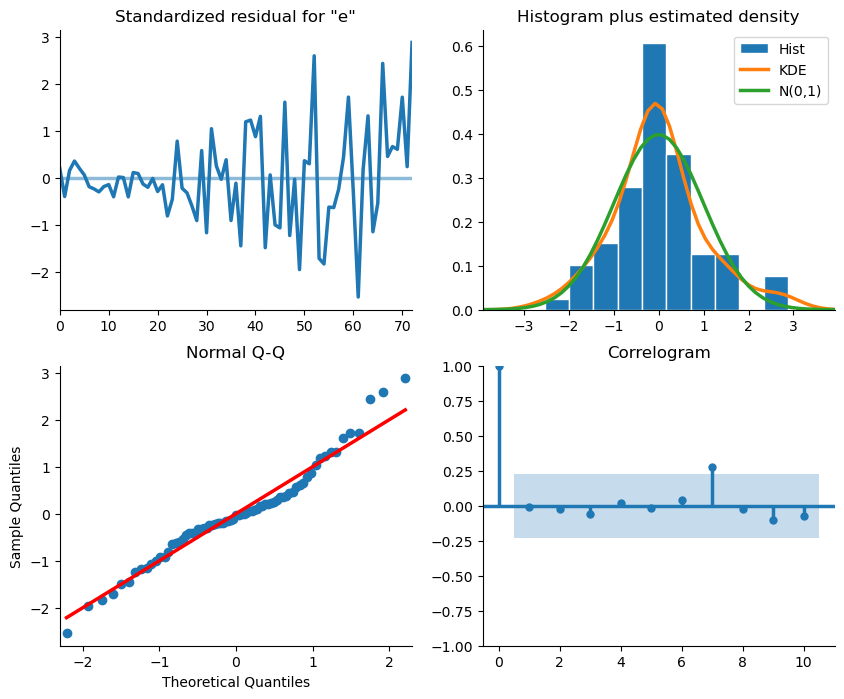

In [212]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [213]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = ARIMA(df[:i], order=(3,0,2))
            result = model.fit()
            predictions = result.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [214]:
pred_df = test.copy()


WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_ARMA

pred_df

,eps_diff2,pred_mean,pred_last_value,pred_ARMA
73,-3.33,0.002329,-0.09,-0.717303
74,8.37,-0.042703,-3.33,7.110877
75,-6.21,0.069467,8.37,-5.628698
76,2.97,-0.013158,-6.21,1.432512
77,-6.75,0.025584,2.97,-5.880842
78,11.07,-0.061282,-6.75,10.554691
79,-7.74,0.079620,11.07,-7.803483
80,2.88,-0.018125,-7.74,3.492359
81,-5.76,0.017654,2.88,-5.386801


In [215]:
# ARIMA_pred = model_fit.get_prediction(73, 81).predicted_mean
# ARIMA_pred


In [216]:
# test['ARIMA_pred'] = ARIMA_pred.values
# test

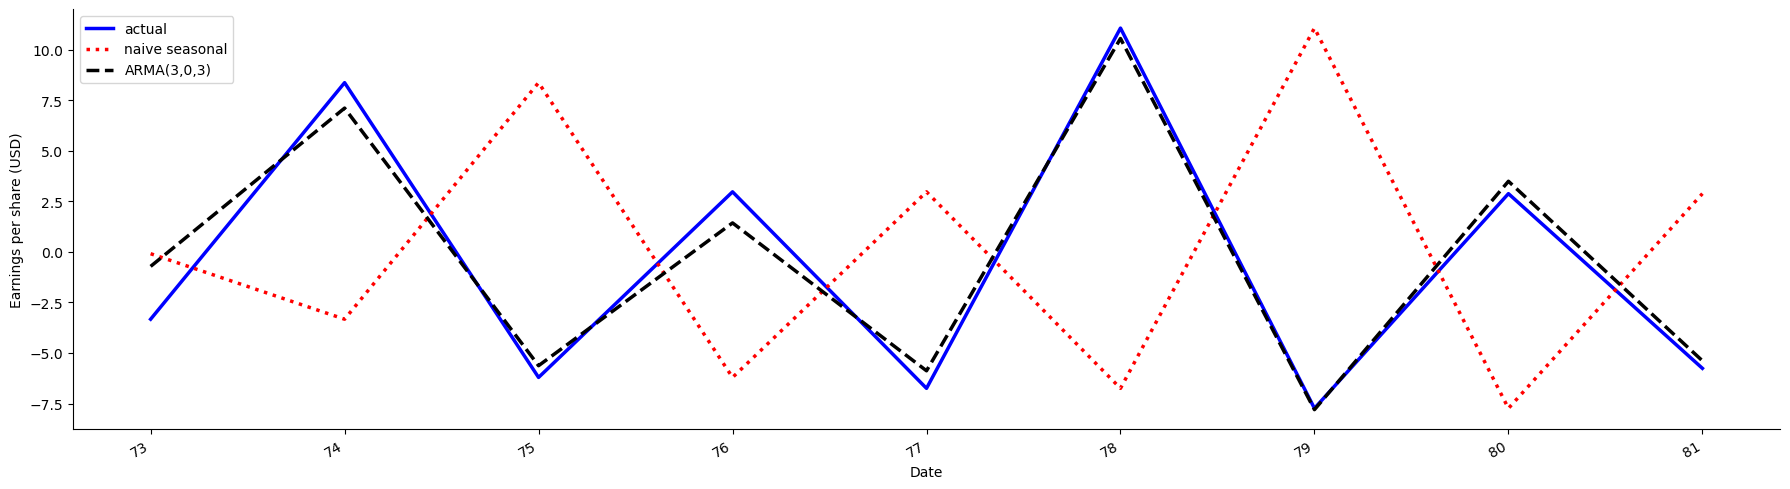

In [217]:
fig, ax = plt.subplots()

# ax.plot(df['data'])
ax.plot(pred_df['eps_diff2'], 'b-', label='actual')
ax.plot(pred_df['pred_last_value'], 'r:', label='naive seasonal')
ax.plot(pred_df['pred_ARMA'], 'k--', label='ARMA(3,0,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
# ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

# plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
# ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [218]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [219]:
mape_naive_seasonal = mape(pred_df['eps_diff2'], pred_df['pred_last_value'])
mape_ARMA = mape(pred_df['eps_diff2'], pred_df['pred_ARMA'])

print(mape_naive_seasonal, mape_ARMA)

205.30051409894102 22.302656713236743


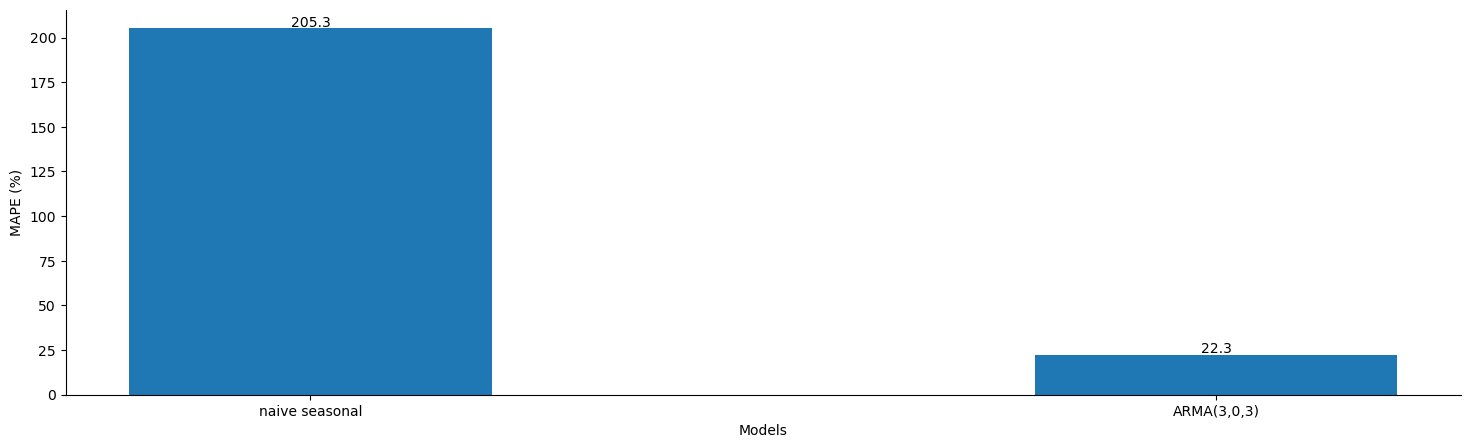

In [220]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARMA(3,0,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
